## Create dataframe

In [8]:
df=pd.read_excel('C:/Users/janyl/OneDrive/Documents/Internship_Prague/data_to_work/data_full.xlsx')
df.columns

Index(['Date', 'Sales '], dtype='object')

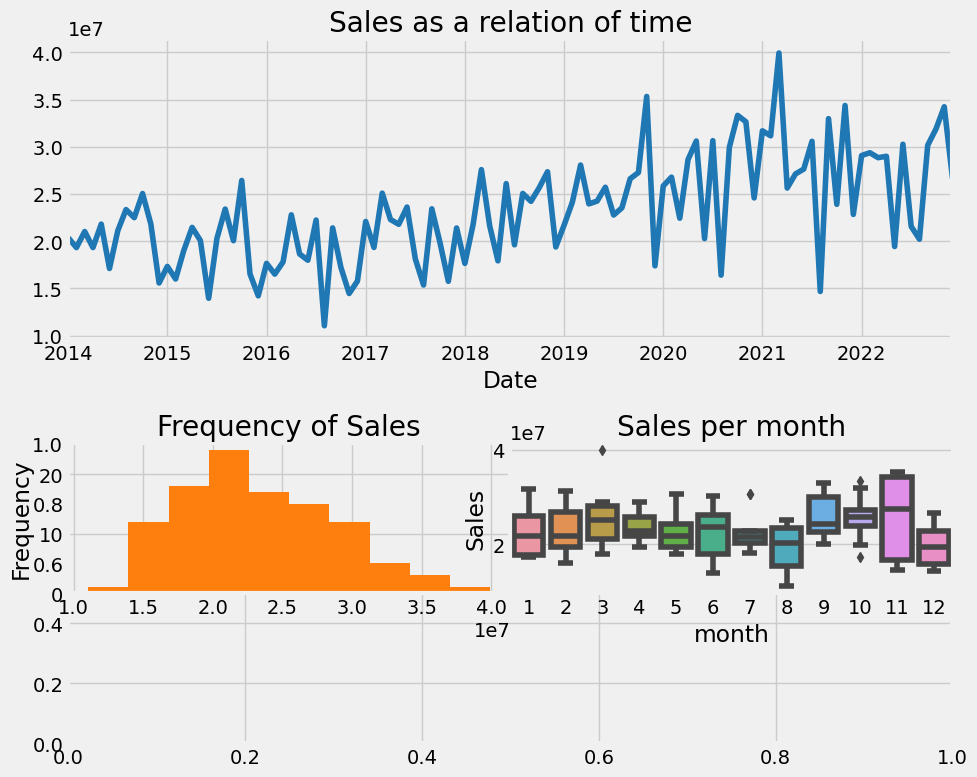

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from timeseries_boosted import  createTimeSeriesDf, createTimeSeriesInflationDf, plotDataSummary, addLags
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

features = ['quarter', 'month', 'lag1','lag2','lag3','inflationCZK']
target = 'Sales'
cutoffDate = '01-01-2020'

df = createTimeSeriesDf('C:/Users/janyl/OneDrive/Documents/Internship_Prague/data_to_work/data_full.xlsx', dateformat='%Y-%m-%d %H:%M:%S')
df_infl = createTimeSeriesInflationDf('C:/Users/janyl/OneDrive/NewAnaconda/pandas/pandas/EU_17_inflation_OECD.xlsx')
plotDataSummary(df)
plotDataSummary(df_infl, colname='inflationCZK')
plt.show()
df = addLags(df)
df = df.dropna()

concatenated = pd.concat([df, df_infl], axis=1)
df = concatenated.loc[:,~concatenated.columns.duplicated()].dropna()
df.tail(10)


## Train on dataset

In [185]:
train = df.loc[df.index < cutoffDate]
test = df.loc[df.index >= cutoffDate]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_all = df[features]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=10);

[0]	validation_0-rmse:21345488.70289	validation_1-rmse:28065299.63530
[10]	validation_0-rmse:19416665.65796	validation_1-rmse:26137192.98441
[20]	validation_0-rmse:17677852.10650	validation_1-rmse:24396864.44852
[30]	validation_0-rmse:16111852.08713	validation_1-rmse:22826666.28131
[40]	validation_0-rmse:14700790.59006	validation_1-rmse:21463219.51274
[50]	validation_0-rmse:13424396.43891	validation_1-rmse:20304641.71979
[60]	validation_0-rmse:12271490.97707	validation_1-rmse:19189488.85301
[70]	validation_0-rmse:11231197.01199	validation_1-rmse:18114065.92219
[80]	validation_0-rmse:10292435.94882	validation_1-rmse:17116879.40640
[90]	validation_0-rmse:9445108.01260	validation_1-rmse:16190217.61169
[100]	validation_0-rmse:8676093.26318	validation_1-rmse:15387133.64613
[110]	validation_0-rmse:7978049.27511	validation_1-rmse:14630423.79719
[120]	validation_0-rmse:7343368.24409	validation_1-rmse:13956224.58248
[130]	validation_0-rmse:6764708.85323	validation_1-rmse:13364225.40985
[140]	va

## Predict & Plot the fitted data

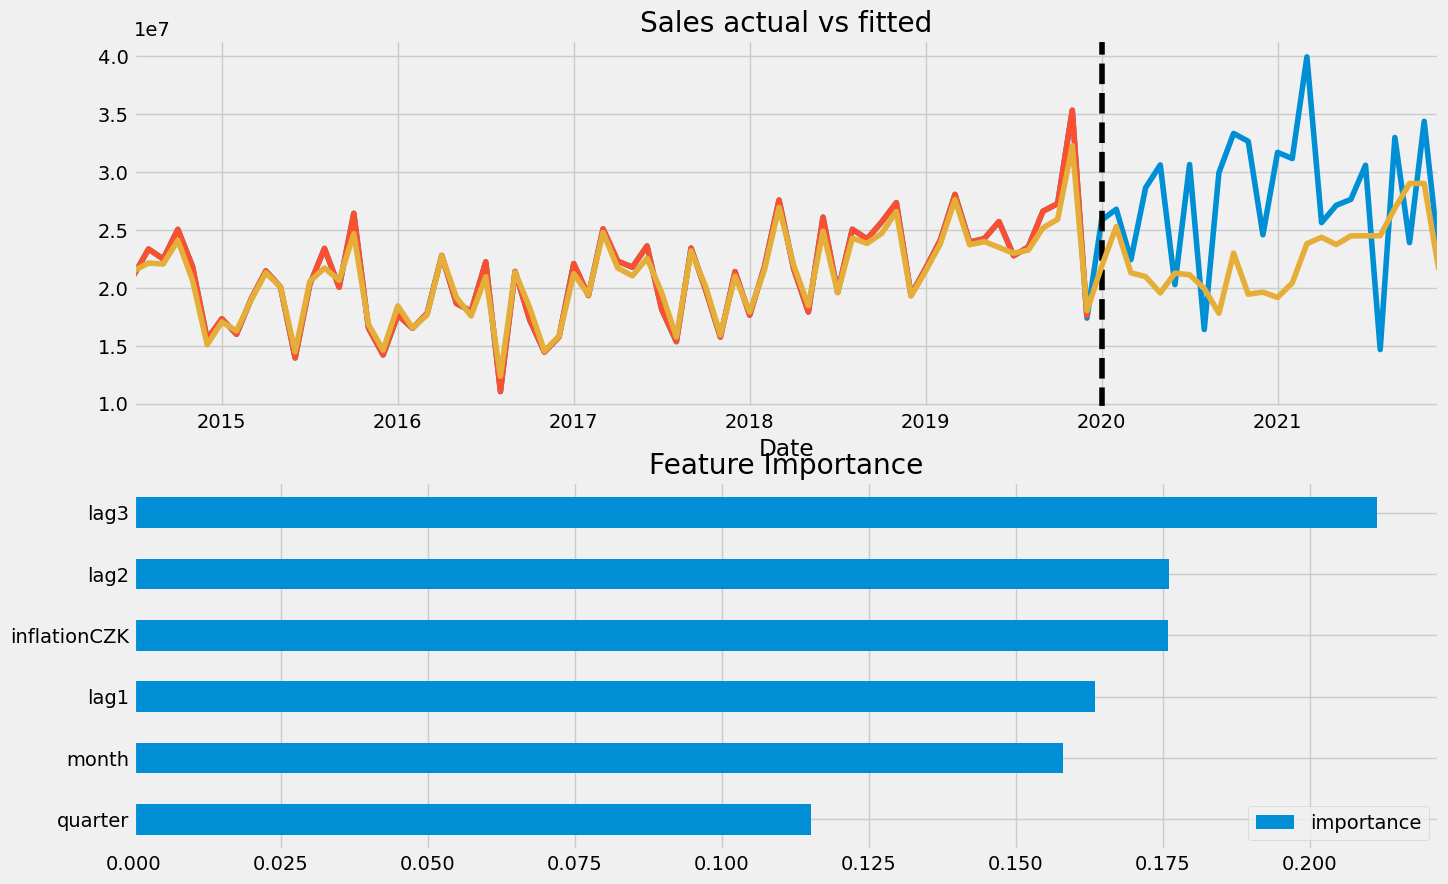

In [186]:
y_pred = reg.predict(X_all)
df['pred'] = y_pred

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df['Sales'].plot(ax=ax[0],
                        label='Actual',
                        title=f'Sales actual vs fitted')
train['Sales'].plot(ax=ax[0], label='train')
ax[0].axvline(cutoffDate, color='black', ls='--')
df['pred'].plot(ax=ax[0],
                        label='Fit')

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax[1])
plt.show()

## Predict the future

In [187]:
X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.01)
reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all), (X_all, y_all)],
            verbose=False);

future = pd.date_range(df.index.max() + pd.offsets.MonthBegin(1), periods = 4, freq='MS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_and_future = pd.concat([df, future_df])
df_and_future['isFuture'] = df_and_future['isFuture'].fillna(False)
df_and_future = addLags(df_and_future)
df_and_future['isFuture'] = df_and_future['isFuture'].fillna(True)
# df_and_future = df_and_future.dropna()
df_and_future.update(df_infl[(df_infl.index <= df_and_future.index.max()) & (df_infl.index >= df_and_future.index.min()) ])
df_and_future['isFuture'].fillna(False, inplace=True)
df_and_future['quarter']= df_and_future.index.quarter
df_and_future['month']=df_and_future.index.month
df_and_future['year']=df_and_future.index.year

X_all_and_future = df_and_future[features]
y_all_and_future = df_and_future[target]
# # # df_and_future
df_and_future['pred'] = reg.predict(X_all_and_future)
future_df = df_and_future.query('isFuture').copy()
df_and_future

,Sales,quarter,month,year,lag1,lag2,lag3,inflationCZK,pred,isFuture
2014-07-01,21100263.32,3,7,2014,NaN,NaN,NaN,0.378702,18049330.0,False
2014-08-01,23348085.73,3,8,2014,NaN,NaN,NaN,0.286067,18982542.0,False
2014-09-01,22493683.18,3,9,2014,NaN,NaN,NaN,0.244391,18979370.0,False
2014-10-01,25046267.60,4,10,2014,NaN,NaN,NaN,0.202715,19320226.0,False
2014-11-01,21840303.11,4,11,2014,21100263.32,NaN,NaN,0.161038,18266574.0,False
...,...,...,...,...,...,...,...,...,...,...
2021-12-01,22832972.44,4,12,2021,14678815.32,30578010.06,27635966.69,5.123924,22896868.0,False
2022-01-01,NaN,1,1,2022,32975860.80,14678815.32,30578010.06,5.625328,28977896.0,True
2022-02-01,NaN,1,2,2022,23905648.49,32975860.80,14678815.32,6.126733,21933710.0,True
2022-03-01,NaN,1,3,2022,34369411.26,23905648.49,32975860.80,6.765226,26215062.0,True


## Plot future

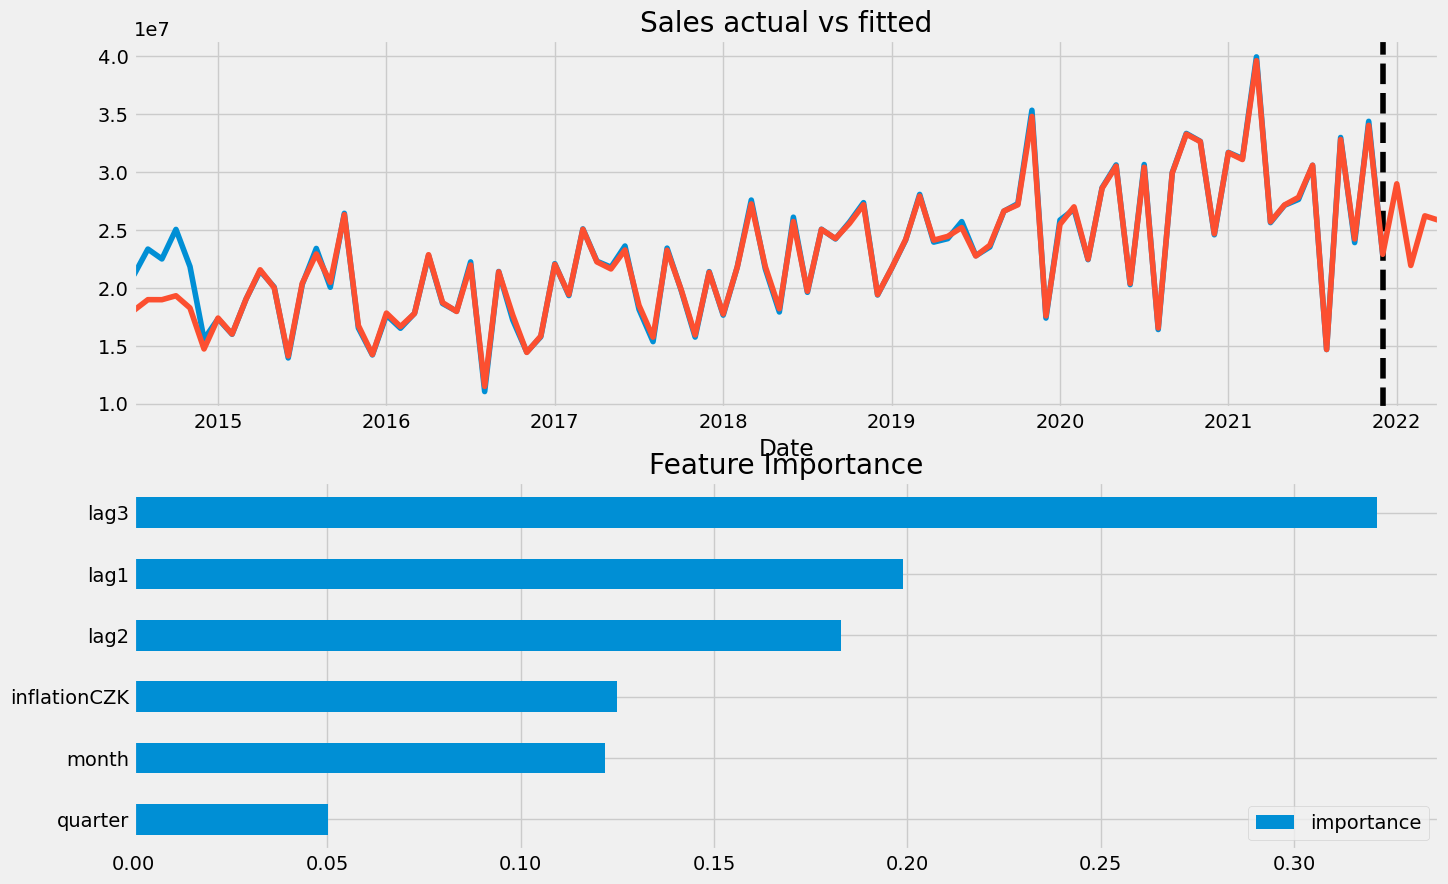

In [188]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df['Sales'].plot(ax=ax[0],
                        label='Existing',
                        title=f'Sales actual vs fitted')
ax[0].axvline(df.index.max(), color='black', ls='--')
df_and_future['pred'].plot(ax=ax[0],
                        label='Prediction')

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax[1])
plt.show()

## Conclusion

EU Inflation doesn't seem to improve the prediction quality significantly